In [ ]:
import pandas as pd
import gc
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import nlpaug.augmenter.word as naw

tqdm.pandas()

# Loading data
X_train = pd.read_csv('/Users/vitmer/Documents/Jupyter/Project/X_train_update.csv')
X_test = pd.read_csv('/Users/vitmer/Documents/Jupyter/Project/X_test_update.csv')
Y_train = pd.read_csv('/Users/vitmer/Documents/Jupyter/Project/Y_train_update.csv')
gc.collect()

# Creating a new column with the required format
X_train['label'] = 'image_' + X_train['imageid'].astype(str) + '_product_' + X_train['productid'].astype(str) + '.jpg'
X_test['label'] = 'image_' + X_test['imageid'].astype(str) + '_product_' + X_test['productid'].astype(str) + '.jpg'

# Function to determine the language based on keywords
def basic_language_detect(text):
    if re.search(r'\b(le|la|les|un|une|des)\b', text, re.IGNORECASE):
        return 'fr'  # French
    elif re.search(r'\b(the|and|of|in|to)\b', text, re.IGNORECASE):
        return 'en'  # English
    elif re.search(r'\b(el|la|los|las|un|una|unos|unas)\b', text, re.IGNORECASE):
        return 'es'  # Spanish
    else:
        return 'unknown'

# Applying the function to determine the language in the 'designation' and 'description' columns
X_train['designation_language'] = X_train['designation'].apply(basic_language_detect)
X_train['description_language'] = X_train['description'].fillna('').apply(basic_language_detect)
X_test['designation_language'] = X_test['designation'].apply(basic_language_detect)
X_test['description_language'] = X_test['description'].fillna('').apply(basic_language_detect)

# Manually defined stop words
manual_stopwords = set("""
a about above after again against all am an and any are aren't as at be because been before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor
un une des du le la les et à en dans par pour au aux avec ce cette ces comme il elle ils elles que qui sur son sa ses leur leurs où donc ne pas ni non plus on nous vous votre vos c'est ce sont car même si mais ou où or ni soit ni puis
""".split())

# Function to preprocess text without NLTK
def simple_preprocess_text(text):
    tokens = re.findall(r'\b\w\w+\b', text.lower())
    filtered_tokens = [word for word in tokens if word not in manual_stopwords and len(word) > 2]
    return ' '.join(filtered_tokens)

# Applying preprocessing to the 'designation' and 'description' columns
X_train['designation_cleaned'] = X_train['designation'].apply(simple_preprocess_text)
X_train['description_cleaned'] = X_train['description'].fillna('').apply(simple_preprocess_text)
X_test['designation_cleaned'] = X_test['designation'].apply(simple_preprocess_text)
X_test['description_cleaned'] = X_test['description'].fillna('').apply(simple_preprocess_text)

# Data augmentation
synonym_aug = naw.SynonymAug(aug_src='wordnet')

def augment_text(text):
    return synonym_aug.augment(text)

X_train['designation_aug'] = X_train['designation_cleaned'].progress_apply(augment_text)
X_train['description_aug'] = X_train['description_cleaned'].progress_apply(augment_text)

# Including the 'prdtypecode' column in the cleaned data
X_train_cleaned = X_train.copy()
Y_train_cleaned = Y_train.copy()

# Removing potentially conflicting columns
X_train_cleaned = X_train_cleaned.drop(columns=['Unnamed: 0'], errors='ignore')
Y_train_cleaned = Y_train_cleaned.drop(columns=['Unnamed: 0'], errors='ignore')

# Merging DataFrames
X_train_cleaned = X_train_cleaned.merge(Y_train_cleaned, left_index=True, right_index=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
from tqdm import tqdm
import os
from PIL import Image, ImageOps
import numpy as np
import gc
import re

# Enable mixed precision if supported
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
except ImportError:
    print("Mixed precision not supported, continuing without it.")

# Paths to image directories
train_image_dir = '/Users/vitmer/Documents/Jupyter/Project/image_train'
test_image_dir = '/Users/vitmer/Documents/Jupyter/Project/image_test'

# Converting labels to dictionaries for easy lookup
train_labels = dict(zip(X_train_cleaned['imageid'].astype(str), X_train_cleaned['productid'].astype(str)))
test_labels = dict(zip(X_test_cleaned['imageid'].astype(str), X_test_cleaned['productid'].astype(str)))

# Function for preprocessing an image using PIL
def preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).convert('RGB')
    image = ImageOps.fit(image, target_size, Image.LANCZOS)
    image = np.array(image) / 255.0
    return image

# Function for preprocessing and augmenting an image using TensorFlow
def load_and_preprocess_image(image_path):
    image = preprocess_image(image_path)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image

# Function for extracting image features using EfficientNetB0
def extract_features_from_directory(image_dir, labels, model, batch_size=8):
    image_paths = []
    for f in os.listdir(image_dir):
        if f.endswith('.jpg'):
            # Extracting image_id and product_id from filename
            match = re.match(r'image_(\d+)_product_(\d+)\.jpg', f)
            if match:
                image_id, product_id = match.groups()
                # Checking that the image is in the labels
                if image_id in labels and labels[image_id] == product_id:
                    image_paths.append(os.path.join(image_dir, f))
    if not image_paths:
        print(f"No images found in directory: {image_dir}")
        return np.array([])

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: tf.numpy_function(load_and_preprocess_image, [x], tf.float32), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    features = []
    for batch in tqdm(dataset, desc="Extracting features from images"):
        batch_features = model.predict(batch)
        features.extend(batch_features)
        gc.collect()
    return np.array(features)

# Function for building and compiling the EfficientNetB0 model
def build_image_model(input_size=(224, 224, 3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_size)
    x = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=x)
    
    # Compile using mixed precision if enabled
    if policy == 'mixed_float16':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
    else:
        optimizer = 'adam'

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and compile the model
image_model = build_image_model(input_size=(224, 224, 3))

# Extract image features for the training and test sets
train_image_features = extract_features_from_directory(train_image_dir, train_labels, image_model, batch_size=8)
gc.collect()
test_image_features = extract_features_from_directory(test_image_dir, test_labels, image_model, batch_size=8)
gc.collect()

# Save the image features
np.save('/Users/vitmer/Documents/Jupyter/Project/train_image_features.npy', train_image_features)
np.save('/Users/vitmer/Documents/Jupyter/Project/test_image_features.npy', test_image_features)

print("Feature extraction completed and saved to disk.")

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import gc
import os

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Function to free up memory
def free_memory():
    gc.collect()

# Load text features
X_train_tfidf = np.load('/Users/vitmer/Documents/Jupyter/Project/X_train_tfidf_all.npy')
Y_train_encoded = np.load('/Users/vitmer/Documents/Jupyter/Project/Y_train_encoded_all.npy')
X_test_tfidf = np.load('/Users/vitmer/Documents/Jupyter/Project/X_test_tfidf_all.npy')

# Load image features
train_image_features = np.load('/Users/vitmer/Documents/Jupyter/Project/train_image_features.npy')
test_image_features = np.load('/Users/vitmer/Documents/Jupyter/Project/test_image_features.npy')

# Encode labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train_encoded)

# Free up memory
free_memory()

# Balance dataset using SMOTE in batches
smote = SMOTE(random_state=42)
batch_size = 10000  # Batch size for SMOTE

def smote_in_batches(X, y, image_features, batch_size, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    X_resampled = []
    y_resampled = []
    image_features_resampled = []
    
    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        X_batch, y_batch = X[start:end], y[start:end]
        image_batch = image_features[start:end]
        X_res, y_res = smote.fit_resample(X_batch, y_batch)
        
        # Calculate the number of new samples added by SMOTE
        new_samples_count = len(X_res) - len(X_batch)
        if new_samples_count > 0:
            new_indices = np.random.choice(len(image_batch), new_samples_count, replace=True)
            image_res = np.concatenate([image_batch, image_batch[new_indices]])
        else:
            image_res = image_batch
        
        # Save the resampled batches to disk
        np.save(os.path.join(output_dir, f'X_resampled_{start}_{end}.npy'), X_res)
        np.save(os.path.join(output_dir, f'y_resampled_{start}_{end}.npy'), y_res)
        np.save(os.path.join(output_dir, f'image_resampled_{start}_{end}.npy'), image_res)

output_dir = '/Users/vitmer/Documents/Jupyter/Project/resampled_batches'
smote_in_batches(X_train_tfidf, Y_train_encoded, train_image_features, batch_size, output_dir)

# Free up memory
free_memory()

# Load all resampled batches from disk and concatenate them
X_train_tfidf_balanced = np.vstack([np.load(os.path.join(output_dir, f'X_resampled_{start}_{end}.npy')) for start, end in 
                                    [(i, min(i + batch_size, len(X_train_tfidf))) for i in range(0, len(X_train_tfidf), batch_size)]])
Y_train_encoded_balanced = np.hstack([np.load(os.path.join(output_dir, f'y_resampled_{start}_{end}.npy')) for start, end in 
                                      [(i, min(i + batch_size, len(X_train_tfidf))) for i in range(0, len(X_train_tfidf), batch_size)]])
train_image_features_balanced = np.vstack([np.load(os.path.join(output_dir, f'image_resampled_{start}_{end}.npy')) for start, end in 
                                           [(i, min(i + batch_size, len(X_train_tfidf))) for i in range(0, len(X_train_tfidf), batch_size)]])

# Split balanced data into 85% (train + validation) and 15% (test)
X_train_val_text, X_test_text, y_train_val, y_test = train_test_split(X_train_tfidf_balanced, Y_train_encoded_balanced, test_size=0.15, random_state=42)
train_val_image_features, test_image_features = train_test_split(train_image_features_balanced, test_size=0.15, random_state=42)

# Check sizes
assert len(X_train_val_text) == len(train_val_image_features), f"Size mismatch: X_train_val_text ({len(X_train_val_text)}) and train_val_image_features ({len(train_val_image_features)})"
assert len(X_test_text) == len(test_image_features), f"Size mismatch: X_test_text ({len(X_test_text)}) and test_image_features ({len(test_image_features)})"

# Free up memory
free_memory()

# Split 85% data into 80% (train) and 20% (validation)
X_train_text, X_val_text, y_train, y_val = train_test_split(X_train_val_text, y_train_val, test_size=0.2, random_state=42)
train_image_features_balanced, val_image_features = train_test_split(train_val_image_features, test_size=0.2, random_state=42)

# Check sizes
assert len(X_train_text) == len(train_image_features_balanced), f"Size mismatch: X_train_text ({len(X_train_text)}) and train_image_features_balanced ({len(train_image_features_balanced)})"
assert len(X_val_text) == len(val_image_features), f"Size mismatch: X_val_text ({len(X_val_text)}) and val_image_features ({len(val_image_features)})"

# Free up memory
free_memory()

# Define model
def build_model(input_shape_text, input_shape_image):
    text_input = Input(shape=(input_shape_text,), name='text_input')
    x1 = Dense(512, activation='relu')(text_input)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.5)(x1)

    image_input = Input(shape=(input_shape_image,), name='image_input')
    x2 = Dense(256, activation='relu')(image_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)

    combined = concatenate([x1, x2])

    x = Dense(64, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    output = Dense(len(np.unique(Y_train_encoded)), activation='softmax')(x)

    model = Model(inputs=[text_input, image_input], outputs=output)
    model.compile(optimizer=Nadam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train model
model = build_model(X_train_text.shape[1], train_image_features_balanced.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Free up memory
free_memory()

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train model with balanced data
history = model.fit([X_train_text, train_image_features_balanced], y_train, 
                    epochs=20, batch_size=64, class_weight=class_weights, 
                    validation_data=([X_val_text, val_image_features], y_val), 
                    callbacks=[early_stopping, reduce_lr])

# Save trained model
model.save('/Users/vitmer/Documents/Jupyter/Project/simple_model.h5')

# Free up memory after saving model
free_memory()

Epoch 1/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.3439 - loss: 2.5038 - val_accuracy: 0.7015 - val_loss: 1.0261 - learning_rate: 1.0000e-04
Epoch 2/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.7084 - loss: 1.0368 - val_accuracy: 0.7814 - val_loss: 0.7631 - learning_rate: 1.0000e-04
Epoch 3/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.7745 - loss: 0.7709 - val_accuracy: 0.8153 - val_loss: 0.6276 - learning_rate: 1.0000e-04
Epoch 4/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.8121 - loss: 0.6351 - val_accuracy: 0.8343 - val_loss: 0.5666 - learning_rate: 1.0000e-04
Epoch 5/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.8387 - loss: 0.5479 - val_accuracy: 0.8615 - val_loss: 0.4584 - learning_rate: 1.0000e-04
Epoch 6/20
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.8565 - loss: 0.4844 - val_accuracy: 0.8795 - val_loss: 0.4102 - learning_rate: 1.0000e-04
Epoch 7/20
2929/2929 ━━━━━━━━━━━━━━━━━━━

5858/5858 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Training set accuracy:
Accuracy: 95.20%
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy on test set: 91.58%
Test set classification report:
              precision    recall  f1-score   support

           0       0.52      0.85      0.64      1580
           1       0.86      0.79      0.82      1519
           2       0.97      0.97      0.97      1526
           3       1.00      1.00      1.00      1561
           4       0.91      0.89      0.90      1548
           5       0.93      0.85      0.89      1582
           6       0.91      0.88      0.89      1535
           7       0.90      0.83      0.86      1545
           8       0.92      0.91      0.91      1499
           9       0.96      0.92      0.94      1596
          10       1.00      0.99      0.99      1480
          11       0.97      0.96      0.97      1528
          12       0.90      0.92      0.91      1549
          13       0.95      0.94      0.94      1559
 

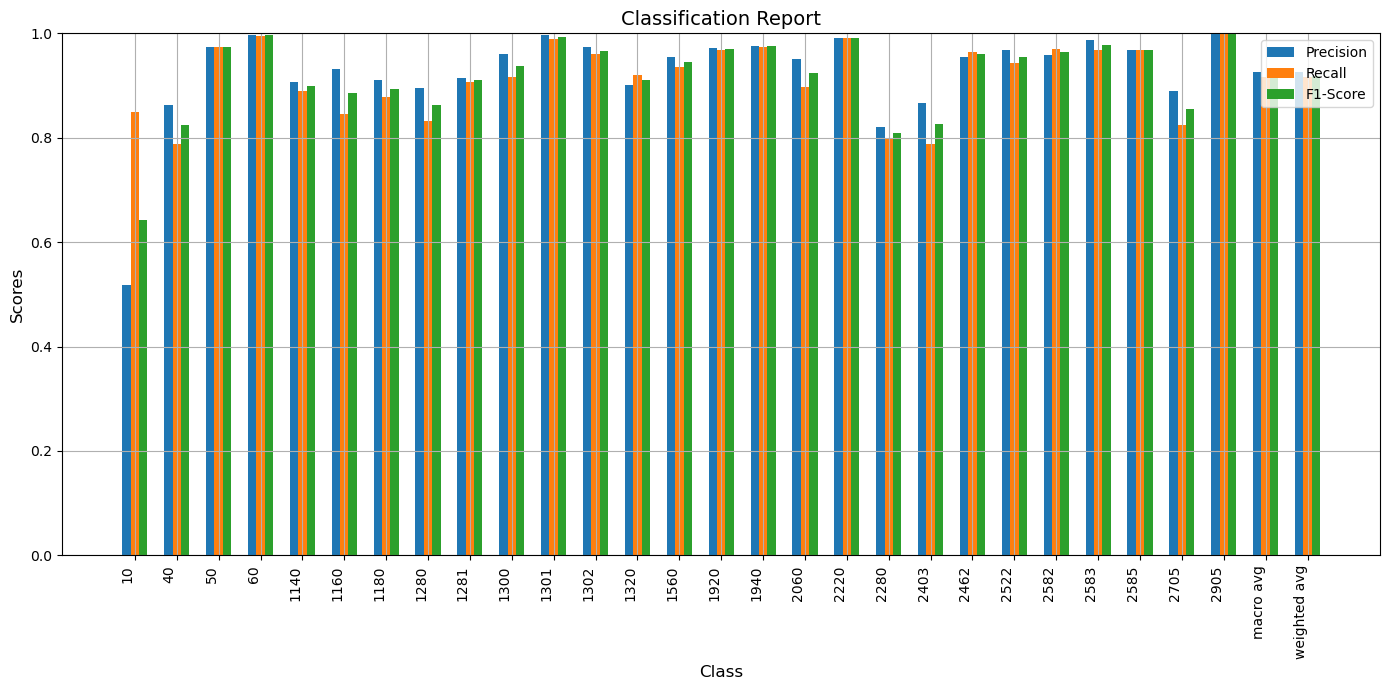

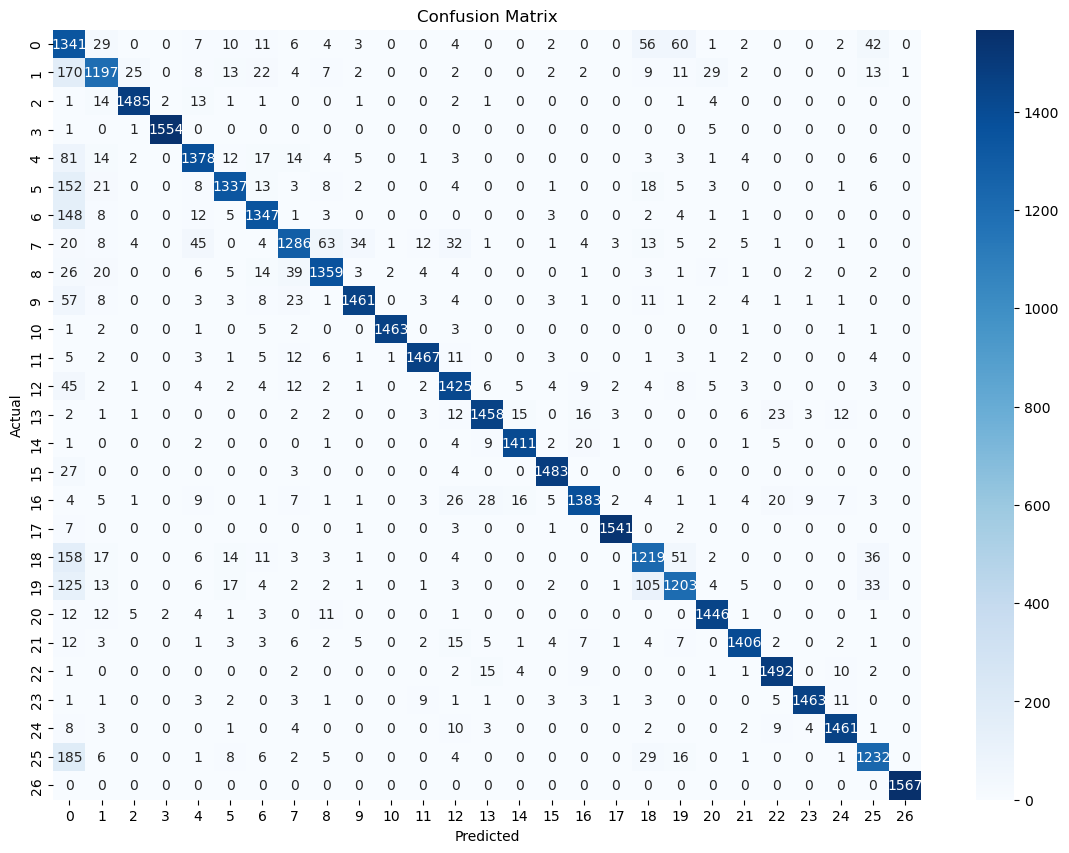

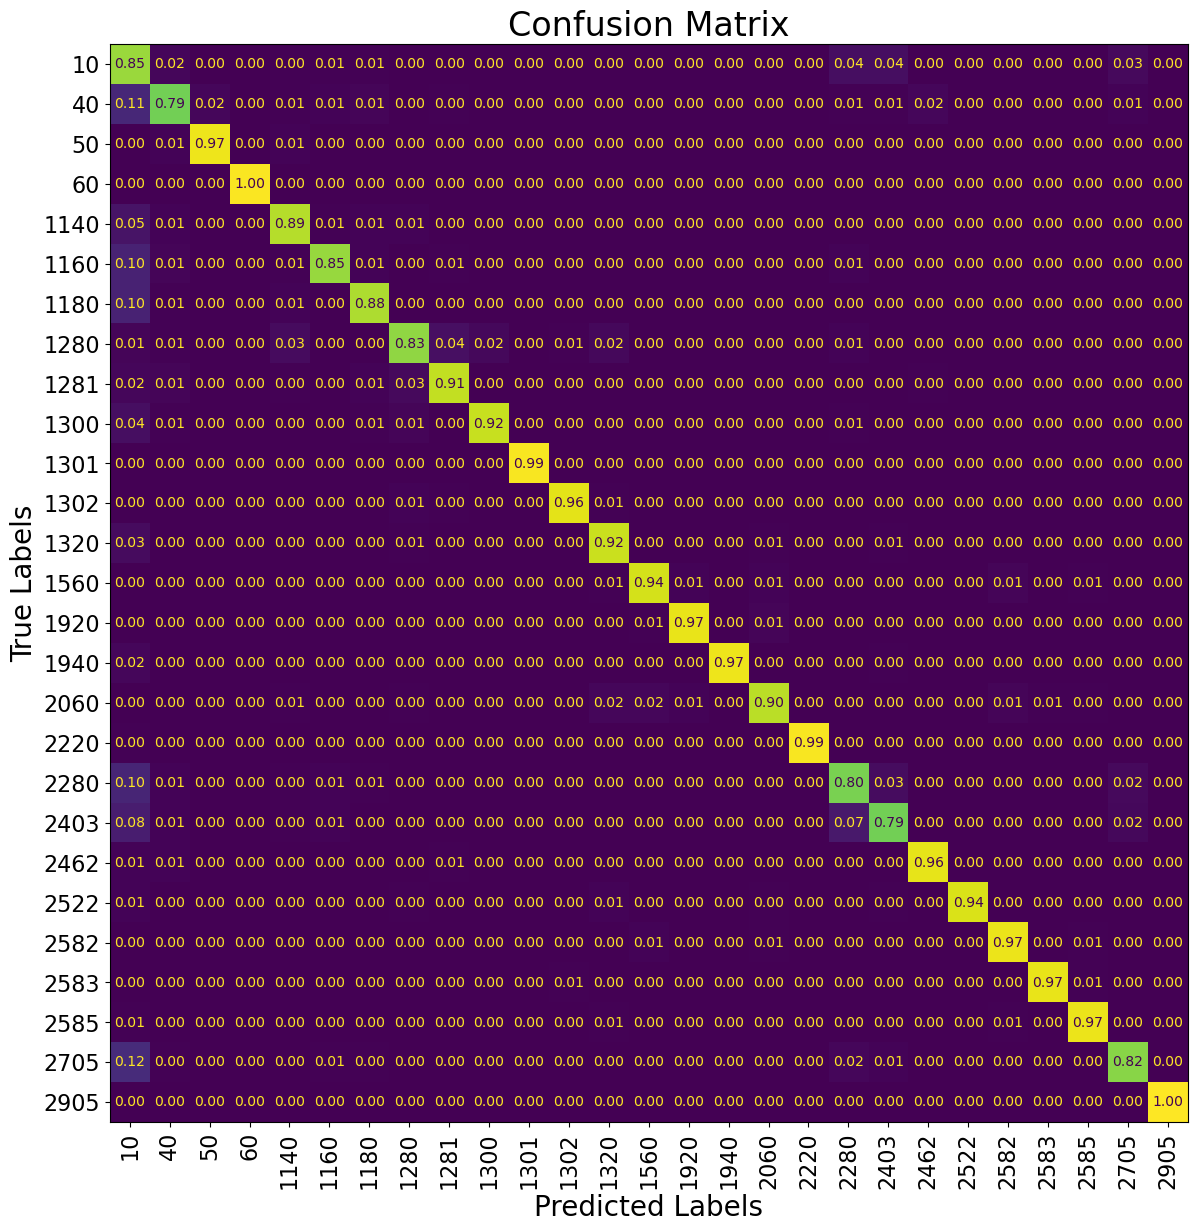

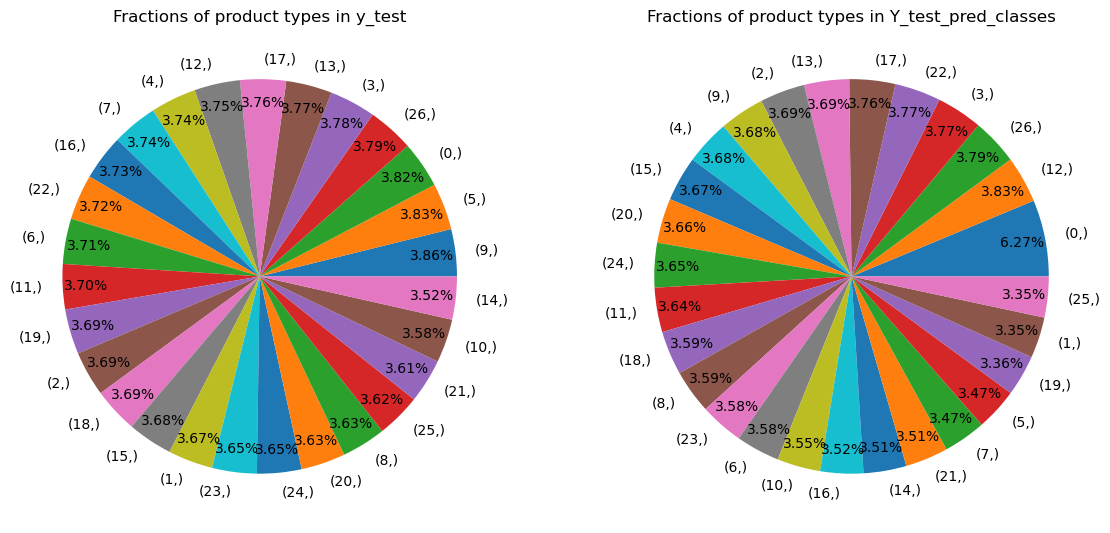

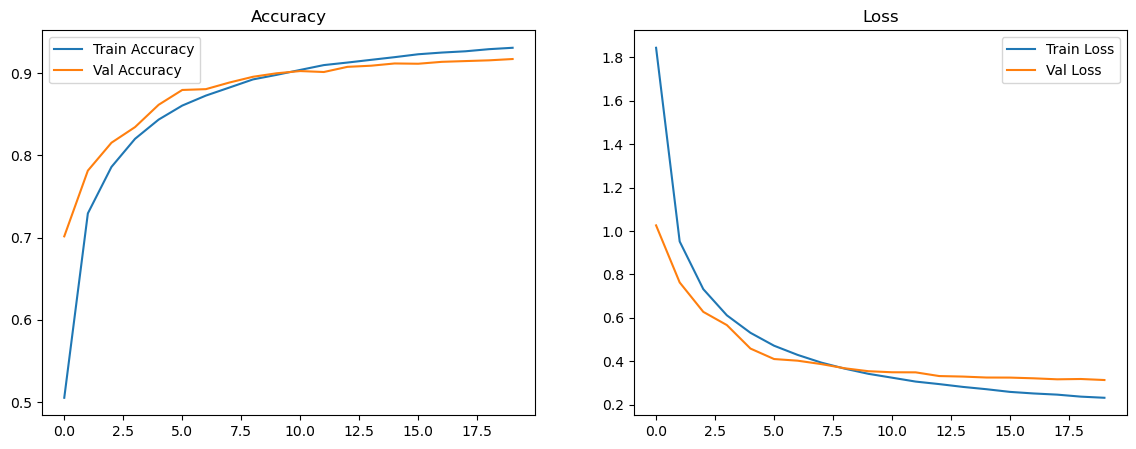

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn import metrics

# Function to free up memory
def free_up_memory():
    gc.collect()

# Assuming number_to_cat is a dictionary that maps class numbers to category labels
number_to_cat = {
    '0': "10", '1': "40", '2': "50", '3': "60", '4': "1140", '5': "1160",
    '6': "1180", '7': "1280", '8': "1281", '9': "1300", '10': "1301",
    '11': "1302", '12': "1320", '13': "1560", '14': "1920", '15': "1940",
    '16': "2060", '17': "2220", '18': "2280", '19': "2403", '20': "2462",
    '21': "2522", '22': "2582", '23': "2583", '24': "2585", '25': "2705",
    '26': "2905", 'macro avg': 'macro avg', 'weighted avg': 'weighted avg'
}

# Assuming these variables are defined in your environment:
# X_train_text, train_image_features_balanced, y_train
# X_test_text, test_image_features, y_test

# Ensure that X_test_text and test_image_features have the same number of samples
min_samples = min(X_test_text.shape[0], test_image_features.shape[0])
X_test_text = X_test_text[:min_samples]
test_image_features = test_image_features[:min_samples]
y_test = y_test[:min_samples]

# Load the trained model
model = tf.keras.models.load_model('/Users/vitmer/Documents/Jupyter/Project/simple_model.h5')

# Evaluate model on training set
Y_train_pred = model.predict([X_train_text, train_image_features_balanced], batch_size=32)
Y_train_pred_classes = np.argmax(Y_train_pred, axis=1)
print("Training set accuracy:")
print(f"Accuracy: {accuracy_score(y_train, Y_train_pred_classes) * 100:.2f}%")
gc.collect()

# Make predictions on the reserved 15% test set
Y_test_pred = model.predict([X_test_text, test_image_features])
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)

# Calculate accuracy on test set
accuracy = accuracy_score(y_test, Y_test_pred_classes)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# Generate classification report for test set
report = metrics.classification_report(y_test, Y_test_pred_classes, output_dict=True)
print("Test set classification report:")
print(metrics.classification_report(y_test, Y_test_pred_classes))

# Extract precision, recall, and F1-score for each class
precision = {key: value['precision'] for key, value in report.items() if isinstance(value, dict)}
recall = {key: value['recall'] for key, value in report.items() if isinstance(value, dict)}
f1score = {key: value['f1-score'] for key, value in report.items() if isinstance(value, dict)}

# Adjust labels
cat_labels = np.array([number_to_cat[str(number)] for number in list(precision.keys())])

# Create a bar plot for precision, recall, and F1-score
labels = cat_labels
precision_values = np.array(list(precision.values()))
recall_values = np.array(list(recall.values()))
f1score_values = np.array(list(f1score.values()))

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 7))
ax.grid()
rects1 = ax.bar(x - width, precision_values, width, label='Precision')
rects2 = ax.bar(x, recall_values, width, label='Recall')
rects3 = ax.bar(x + width, f1score_values, width, label='F1-Score')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_xticks(x)
ax.set_ylim(0.0, 1.0)
ax.set_xticklabels(labels, rotation=90, ha='right', fontsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.legend(loc='upper right')
ax.set_title("Classification Report", fontsize=14)

fig.tight_layout()
plt.show()

# Confusion matrix for test set
conf_matrix = confusion_matrix(y_test, Y_test_pred_classes)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix with normalized values
cm_cat_labels = cat_labels[:27]

cm = metrics.confusion_matrix(y_test, Y_test_pred_classes, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_cat_labels)
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, colorbar=False)

plt.xlabel('Predicted Labels', fontsize=20)
plt.ylabel('True Labels', fontsize=20)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Confusion Matrix", fontsize=24)

# Format annotations to show up to three decimal places
for text in ax.texts:
    text.set_text(f'{float(text.get_text()):.2f}')

plt.show()

# Plotting distribution of original and predicted labels on test set
plt.figure(figsize=(14, 7))

# Diagram of the original labels distribution
plt.subplot(1, 2, 1)
original_counts = pd.DataFrame(y_test).value_counts()
plt.pie(original_counts,
        labels=original_counts.index.to_numpy(),
        autopct='%1.2f%%',
        pctdistance=0.88)
plt.title('Fractions of product types in y_test')

# Diagram of the predicted labels distribution
plt.subplot(1, 2, 2)
predicted_counts = pd.DataFrame(Y_test_pred_classes).value_counts()
plt.pie(predicted_counts,
        labels=predicted_counts.index.to_numpy(),
        autopct='%1.2f%%',
        pctdistance=0.88)
plt.title('Fractions of product types in Y_test_pred_classes')

plt.show()

# Plotting accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# Displaying the plots
plt.show()

# Freeing up memory after displaying the confusion matrix
free_up_memory()